学习DID方法。

In [1]:
library(tidyverse)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# 标准DID

## 陈强案例

In [1]:
# 读取数据集
library(foreign)

data_DID <- read.dta("./data/cardkrueger1994.dta")

In [2]:
head(data_DID)

,id,t,treated,fte,bk,kfc,roys,wendys
,<int>,<int>,<fct>,<dbl>,<int>,<int>,<int>,<int>
1,1,0,NJ,31.0,1,0,0,0
2,1,1,NJ,40.0,1,0,0,0
3,2,0,NJ,13.0,1,0,0,0
4,2,1,NJ,12.5,1,0,0,0
5,3,0,NJ,12.5,0,1,0,0
6,3,1,NJ,7.5,0,1,0,0


In [3]:
fit_DID <- lm(fte ~ treated + t + treated:t, data = data_DID)

library(broom)
tidy(fit_DID)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),19.948718,1.019394,19.569198,6.127611e-70
treatedNJ,-2.883534,1.134812,-2.540980,1.124277e-02
t,-2.406510,1.446314,-1.663892,9.652702e-02
treatedNJ:t,2.913982,1.610513,1.809350,7.077328e-02


In [8]:
# 不要科学计数法
options(scipen = 999)

# 使用稳健标准误
library(sandwich)
library(lmtest)
coeftest(fit_DID, vcov = vcovHC(fit_DID, type = "HC1")) %>%
  round(digits = 5) %>%
  tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),19.94872,1.31728,15.14386,0.00000
treatedNJ,-2.88353,1.40334,-2.05477,0.04023
t,-2.40651,1.59409,-1.50964,0.13153
treatedNJ:t,2.91398,1.73682,1.67777,0.09378


In [9]:
# 不要科学计数法
options(scipen = 999)

# 使用聚类稳健标准误
library(sandwich)
library(lmtest)
coeftest(fit_DID, vcov = vcovCL(fit_DID, cluster = ~ id)) %>%
  round(digits = 5) %>%
  tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),19.94872,1.31807,15.13478,0.00000
treatedNJ,-2.88353,1.40180,-2.05703,0.04001
t,-2.40651,1.20711,-1.99362,0.04653
treatedNJ:t,2.91398,1.29145,2.25637,0.02432


In [13]:
# 纳入协变量
fit_DID_cov <- lm(
  fte ~ treated + t + treated:t + bk + kfc + roys,
  data = data_DID
)

# 使用稳健标准误
coeftest(fit_DID_cov, vcov = vcovHC(fit_DID_cov, type = "HC1")) %>% 
  round(digits = 5) %>%
  tidy() %>% 
  # 保存
  write_csv("./fit_DID_cov.csv")

In [11]:
mean_DID <- data_DID  %>% 
  group_by(t, treated) %>% 
  summarise(
    mean_fte = mean(fte,na.rm = TRUE),
  ) %>% 
  mutate(
    treated = as.factor(treated)
  )

mean_DID

`summarise()` has grouped output by 't'. You can override using the `.groups`
argument.


t,treated,mean_fte
<int>,<fct>,<dbl>
0,PA,19.94872
0,NJ,17.06518
1,PA,17.54221
1,NJ,17.57266


# 稳健性检验

In [2]:
library(haven)
hospdd <- read_dta("./data/hospdd.dta")
head(hospdd)

hospital,frequency,month,procedure,satis
<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>
1,3,7,1,4.106527
1,2,3,0,3.319475
1,4,2,0,3.411720
1,2,4,1,3.004025
1,1,3,0,3.110720
1,1,7,1,2.882164


In [181]:
# 处理数据集
hospdd_pre <- hospdd %>% 
  mutate(
    post = ifelse(month >= 4, 1, 0),
    post = as.factor(post),
    treat = procedure,
  ) %>% 
  group_by(hospital) %>% 
  mutate(
    treat = max(treat)
  ) %>% 
  ungroup() %>% 
  mutate(
    treat = as.factor(treat)
  )

head(hospdd_pre)

hospital,frequency,month,procedure,satis,post,treat
<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<fct>,<fct>
1,3,7,1,4.106527,1,1
1,2,3,0,3.319475,0,1
1,4,2,0,3.411720,0,1
1,2,4,1,3.004025,1,1
1,1,3,0,3.110720,0,1
1,1,7,1,2.882164,1,1


In [183]:
# 普通回归
fit_ols <- lm(
  satis ~ post + treat + procedure,
  data = hospdd_pre
)

# 使用聚类稳健标准误
library(broom)
library(sandwich)
library(lmtest)
coeftest(fit_ols, vcov = vcovCL(fit_ols, cluster = ~ hospital)) %>% 
  round(digits = 7) %>%
  tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.3925093,0.1304557,26.0050727,0.0000000
post1,-0.0100198,0.0133172,-0.7523956,0.4518373
treat1,0.1328739,0.2121529,0.6263121,0.5311297
procedure,0.8479879,0.0320051,26.4954049,0.0000000


In [184]:
# 普通回归
fit_ols <- lm(
  satis ~ procedure + frequency + factor(hospital) + factor(month),
  data = hospdd_pre
)

# 使用聚类稳健标准误
library(broom)
library(sandwich)
library(lmtest)
coeftest(fit_ols, vcov = vcovCL(fit_ols, cluster = ~ hospital, type = "HC0")) %>% 
  round(digits = 7) %>%
  tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.0548075,0.0463098,65.9645629,0.0000000
procedure,0.8479879,0.0319986,26.5008013,0.0000000
frequency,0.0537506,0.0188837,2.8464091,0.0044338
factor(hospital)2,0.3692829,0.0138011,26.7574948,0.0000000
factor(hospital)3,0.5316568,0.0006914,768.9652762,0.0000000
factor(hospital)4,0.2390081,0.0040395,59.1683297,0.0000000
factor(hospital)5,-0.1876056,0.0148442,-12.6383110,0.0000000
factor(hospital)6,0.4228110,0.0088014,48.0389145,0.0000000
factor(hospital)7,1.3952296,0.0032275,432.2953301,0.0000000


In [185]:
library(fixest)

In [189]:
library(fixest)

# 拟合模型
fit_fe <- feols(
  satis ~ procedure + frequency | hospital + month,
  cluster = ~hospital,
  data = hospdd_pre
)

# 查看结果
tidy(fit_fe)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
procedure,0.84798786,0.03201596,26.486409,4.360650e-29
frequency,0.05375062,0.01889392,2.844863,6.664126e-03


In [190]:
# 普通回归
fit_ols <- lm(
  satis ~ post + treat + procedure + frequency + hospital,
  data = hospdd_pre
)

# 使用聚类稳健标准误
library(broom)
library(sandwich)
library(lmtest)
coeftest(fit_ols, vcov = vcovCL(fit_ols, cluster = ~ hospital)) %>% 
  round(digits = 7) %>%
  tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.2632144,0.4229171,7.7159678,0.0000000
post1,-0.0100198,0.0133190,-0.7522934,0.4518987
treat1,0.1256177,0.3617300,0.3472692,0.7283990
procedure,0.8479879,0.0320094,26.4918067,0.0000000
frequency,0.0575500,0.0212657,2.7062382,0.0068207
hospital,-0.0004392,0.0124780,-0.0352012,0.9719202


## 平行趋势检验

### 平衡性检验

In [191]:
# 二期面板的平衡性检验
t.test(
  frequency ~ treat,
  data = hospdd_pre,
  subset = (post == 0)
)


	Welch Two Sample t-test

data:  frequency by treat
t = 1.4105, df = 3264.4, p-value = 0.1585
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.02146406  0.13152259
sample estimates:
mean in group 0 mean in group 1 
       2.496283        2.441253 


### 均值绘图法

`summarise()` has grouped output by 'treat'. You can override using the
`.groups` argument.


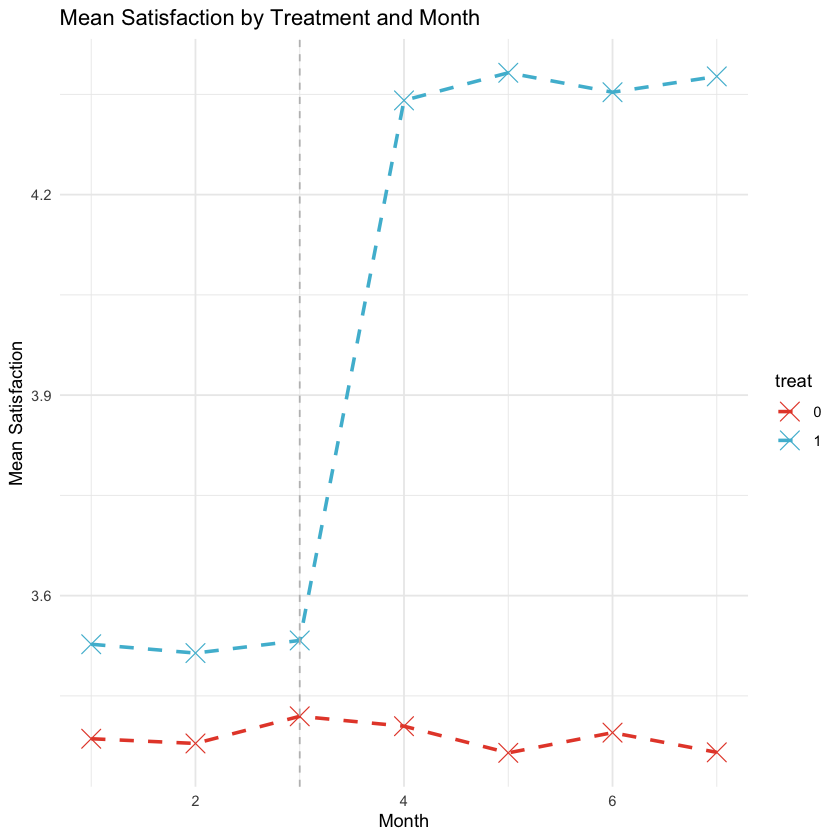

In [211]:
# 按处理与时间计算均值
data_mean <- hospdd_pre %>% 
  group_by(treat, month) %>% 
  summarise(
    mean = mean(satis)
  )

# 绘制均值图
library(ggplot2)
library(ggsci)

ggplot(data_mean, aes(x = month, y = mean, color = treat)) +
  geom_point(size = 5, shape = 4) +
  geom_line(linewidth = 1, linetype = "dashed") +
  geom_vline(xintercept = 3, linetype = "dashed", color = "gray") +
  labs(
    title = "Mean Satisfaction by Treatment and Month",
    x = "Month",
    y = "Mean Satisfaction"
  ) +
  theme_minimal() +
  # npg
  scale_color_npg() +
  scale_fill_npg()

### 拟合值绘图法

`summarise()` has grouped output by 'treat'. You can override using the
`.groups` argument.


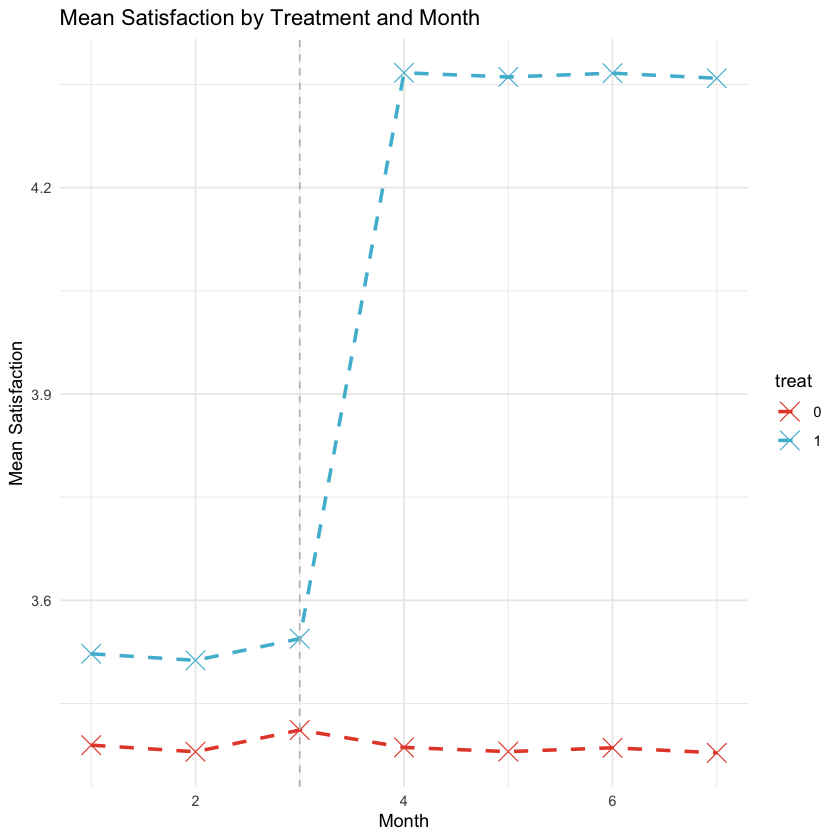

In [255]:
# 预测
hospdd_pre %>% 
  mutate(
    satis = predict(fit_fe),
  ) %>% 
  group_by(treat, month) %>%
  summarise(
    mean = mean(satis)
  ) %>%
  ggplot(aes(x = month, y = mean, color = treat)) +
  geom_point(size = 5, shape = 4) +
  geom_line(linewidth = 1, linetype = "dashed") +
  geom_vline(xintercept = 3, linetype = "dashed", color = "gray") +
  labs(
    title = "Mean Satisfaction by Treatment and Month",
    x = "Month",
    y = "Mean Satisfaction"
  ) +
  theme_minimal() +
  # npg
  scale_color_npg() +
  scale_fill_npg()

### Wald平行系数检验

In [264]:
# 处理数据集
hospdd_pre <- hospdd %>% 
  mutate(
    post = ifelse(month >= 4, 1, 0),
    post = as.factor(post),
    treat = procedure,
  ) %>% 
  group_by(hospital) %>% 
  mutate(
    treat = max(treat)
  ) %>% 
  ungroup() %>% 
  mutate(
    pre = ifelse(month < 4, 1, 0),
    pre = as.factor(pre),
    treat = factor(treat, levels = c(1, 0))
  )

# 构建固定效应模型
fit_fe <- feols(
  satis ~ procedure + frequency + pre:treat:month | hospital + month,
  cluster = ~hospital,
  data = hospdd_pre
)

tidy(fit_fe)

The variables 'pre0:treat0:month' and 'pre1:treat0:month' have been removed because of collinearity (see $collin.var).



term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
procedure,0.73357471,0.08869836,8.2704430,1.397266e-10
frequency,0.05375062,0.01889649,2.8444766,6.670964e-03
pre0:treat1:month,0.01658938,0.01364578,1.2157148,2.304330e-01
pre1:treat1:month,-0.01324090,0.01777458,-0.7449343,4.601845e-01


In [265]:
library(sandwich)
library(car)

linearHypothesis(
  fit_fe,
  "pre0:treat1:month = 0",
  vcov = vcovCL(fit_fe, cluster = ~ hospital),
  test = "Chisq"
)

,Res.Df,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>
1,7313,NA,NA,NA
2,7312,1,1.479971,0.223779


### 事件研究法

In [286]:
# 处理数据集
hospdd_pre <- hospdd %>% 
  mutate(
    post = ifelse(month >= 4, 1, 0),
    post = as.factor(post),
    treat = procedure,
  ) %>% 
  group_by(hospital) %>% 
  mutate(
    treat = max(treat)
  ) %>% 
  ungroup() %>% 
  mutate(
    ic = treat * month,
    treat = factor(treat, levels = c(1, 0)),
    month = as.factor(month),
    ic = as.factor(ic)
  )

# 构建固定效应模型
fit_fe <- feols(
  satis ~ frequency + i(ic, 3) | hospital + month,
  cluster = ~hospital,
  data = hospdd_pre
)

result <- tidy(fit_fe, conf.int = TRUE)
result

The variable 'ic::0' has been removed because of collinearity (see $collin.var).



term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
frequency,0.05375062,0.01890034,2.8438966,6.681237e-03,0.01568337,0.09181786
ic::1,0.02789700,0.03546244,0.7866635,4.356023e-01,-0.04352801,0.09932202
ic::2,0.02173215,0.03789368,0.5735033,5.691592e-01,-0.05458964,0.09805394
ic::4,0.82281528,0.04934501,16.6747424,6.963275e-21,0.72342934,0.92220123
ic::5,0.90404985,0.04682746,19.3059755,2.108194e-23,0.80973450,0.99836520
ic::6,0.84472398,0.06061840,13.9351086,6.190690e-18,0.72263226,0.96681570
ic::7,0.89788850,0.05100553,17.6037476,8.339709e-22,0.79515809,1.00061892


In [300]:
# 提取数据
tibble_0 <- tibble(
  term = "ic::3",
  estimate = 0,
  conf.low = NA,
  conf.high = NA,
)

data_figure <- result %>% 
  filter(str_detect(term, "ic")) %>% 
  select(term, estimate, conf.low, conf.high) %>% 
  bind_rows(tibble_0) %>% 
  mutate(
    order = row_number(),
    order = ifelse(term == "ic::3", 2.5, order)
  ) %>% 
  arrange(order) %>% 
  mutate(term = row_number())

head(data_figure)

term,estimate,conf.low,conf.high,order
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.02789700,-0.04352801,0.09932202,1.0
2,0.02173215,-0.05458964,0.09805394,2.0
3,0.00000000,NA,NA,2.5
4,0.82281528,0.72342934,0.92220123,3.0
5,0.90404985,0.80973450,0.99836520,4.0
6,0.84472398,0.72263226,0.96681570,5.0


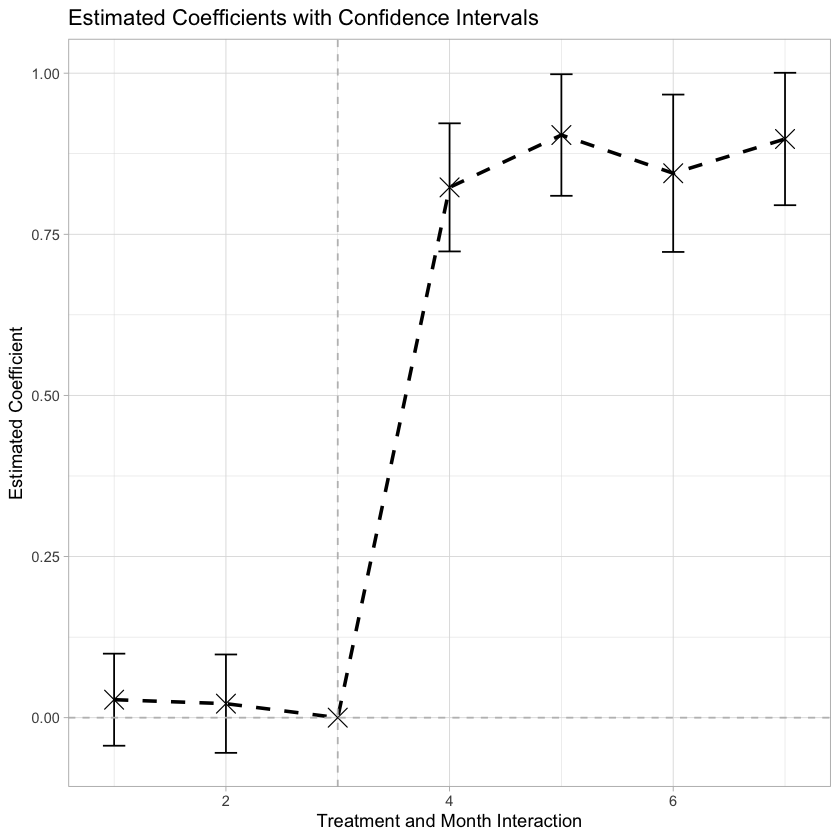

In [305]:
# 绘制折线图
library(ggplot2)
library(ggsci)

ggplot(data_figure, aes(x = term, y = estimate)) +
  geom_point(size = 5, shape = 4) +
  geom_line(linewidth = 1, linetype = "dashed") +
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = 0.2) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "gray") +
  geom_vline(xintercept = 3, linetype = "dashed", color = "gray") +
  labs(
    title = "Estimated Coefficients with Confidence Intervals",
    x = "Treatment and Month Interaction",
    y = "Estimated Coefficient"
  ) +
  theme_light() +
  # npg
  scale_color_npg() +
  scale_fill_npg()

## 安慰剂检验

### 时间安慰剂检验

In [330]:
# 处理数据集
hospdd_pre <- hospdd %>% 
  mutate(
    post = ifelse(month >= 2, 1, 0),
    post = as.factor(post),
    treat = procedure,
  ) %>% 
  group_by(hospital) %>% 
  mutate(treat = max(treat)) %>% 
  ungroup() %>% 
  filter(month <= 3) %>% 
  mutate(fake_post = ifelse(month != 1, 1, 0)) %>% 
  mutate(ic = treat * fake_post)

# 构建固定效应模型
fit_fe <- feols(
  satis ~ i(ic, ref = 0) + frequency | hospital + month,
  cluster = ~hospital,
  data = hospdd_pre
)

tidy(fit_fe)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ic::1,-0.017030928,0.03017482,-0.5644086,0.5752788
frequency,-0.007891041,0.01415732,-0.5573826,0.5800282


### 处理组安慰剂检验

In [10]:
# 载入必要的包
library(fixest)
library(broom)

# 取样1000次
n_sample <- 1000

# 生成空数据框
result_df <- data.frame(
  estimate = numeric(n_sample),
  std.error = numeric(n_sample),
  statistic = numeric(n_sample),
  p.value = numeric(n_sample)
)

# 迭代n=1000次
set.seed(123)  # 设置随机种子以确保结果可重复

for (i in 1:n_sample) {
  # 提取医院ID
  hospital_id <- unique(hospdd$hospital)

  # 随机抽取18家医院
  sample_hospital <- sample(hospital_id, 18)

  # 数据预处理
  hospdd_sample <- hospdd %>% 
  mutate(
    treat = ifelse(hospital %in% sample_hospital, 1, 0),
    procedure = ifelse(month >= 4 & treat == 1, 1, 0),
    hospital = as.factor(hospital),
    month = as.factor(month),
    procedure = as.factor(procedure)
  )

  # 构建固定效应模型
  fit_fe <- feols(
    satis ~ procedure + frequency | hospital + month,
    cluster = ~hospital,
    data = hospdd_sample
  )

  # 提取结果
  result <- tidy(fit_fe)
  result_df[i, ] <- result[1, 2:5]
}

head(result_df)

,estimate,std.error,statistic,p.value
,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.034310665,0.1363436,-0.25164854,0.8024585
2,0.017907734,0.1368398,0.13086638,0.8964643
3,0.098826376,0.1342318,0.73623660,0.4654075
4,0.002267276,0.1338889,0.01693401,0.9865641
5,-0.209292120,0.1272914,-1.64419625,0.1071050
6,-0.097673116,0.1349024,-0.72402809,0.4727960


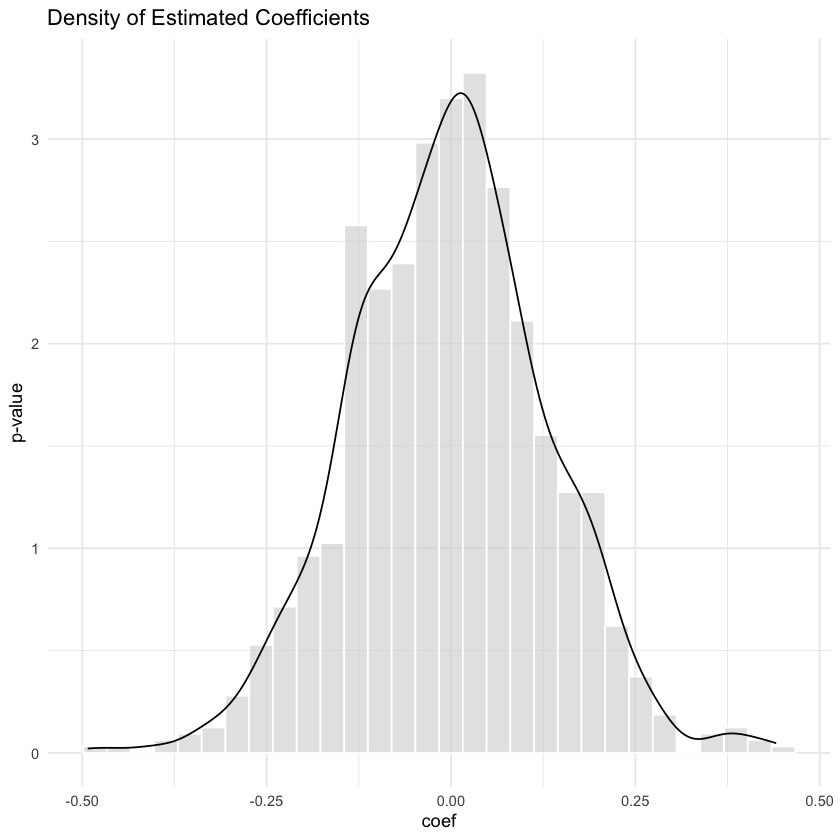

In [23]:
# 绘制系数的核密度曲线以及p值与系数的散点图
library(ggplot2)

ggplot(result_df, aes(x = estimate)) +
  geom_histogram(
    aes(x = estimate, y = after_stat(density)),
    bins = 30, fill = "lightgray", color = "white", alpha = 0.6
  ) +
  geom_density() +
  labs(
    title = "Density of Estimated Coefficients",
    x = "coef",
    y = "p-value"
  ) +
  theme_minimal()

In [38]:
# 数据预处理
hospdd_pre <- hospdd %>% 
  mutate(
    procedure = as.factor(procedure),
    hospital = as.factor(hospital),
    month = as.factor(month)
  )

# 拟合模型
fit_fe <- feols(
  satis ~ procedure + frequency | hospital + month,
  cluster = ~hospital,
  data = hospdd_pre
)

# 提取系数
coef <- tidy(fit_fe)[1, 2]

# 进行双边置换检验
result_df %>% 
  mutate(
    estimate = abs(estimate) >= abs(coef),
    estimate = as.numeric(estimate)
  )  %>% 
  summarise(p_value = mean(estimate))

p_value
<dbl>
0


### 混合安慰剂检验

In [41]:
# 载入必要的包
library(fixest)
library(broom)

# 取样1000次
n_sample <- 1000

# 生成空数据框
result_df <- data.frame(
  estimate = numeric(n_sample),
  std.error = numeric(n_sample),
  statistic = numeric(n_sample),
  p.value = numeric(n_sample)
)

# 迭代n=1000次
set.seed(123)  # 设置随机种子以确保结果可重复
# 提取医院ID
hospital_id <- unique(hospdd$hospital)
# 提取月份
month_id <- unique(hospdd$month)
# 月份中去掉1
month_id <- month_id[month_id != 1]

for (i in 1:n_sample) {
  # 随机抽取18家医院
  sample_hospital <- sample(hospital_id, 18)
  # 随机抽取月份
  sample_month <- sample(month_id, 1)

  # 数据预处理
  hospdd_sample <- hospdd %>% 
  mutate(
    treat = ifelse(hospital %in% sample_hospital, 1, 0),
    post = ifelse(month >= sample_month, 1, 0),
    procedure = post * treat,
    hospital = as.factor(hospital),
    month = as.factor(month),
    procedure = as.factor(procedure)
  )

  # 构建固定效应模型
  fit_fe <- feols(
    satis ~ procedure + frequency | hospital + month,
    cluster = ~hospital,
    data = hospdd_sample
  )

  # 提取结果
  result <- tidy(fit_fe)
  result_df[i, ] <- result[1, 2:5]
}

head(result_df)

,estimate,std.error,statistic,p.value
,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.018763407,0.10854204,-0.17286763,0.8635307
2,-0.006857571,0.09349777,-0.07334476,0.9418568
3,-0.015737602,0.13344300,-0.11793501,0.9066440
4,-0.007216835,0.13360684,-0.05401546,0.9571619
5,-0.171334010,0.10675195,-1.60497308,0.1154958
6,-0.037835463,0.09481978,-0.39902502,0.6917621


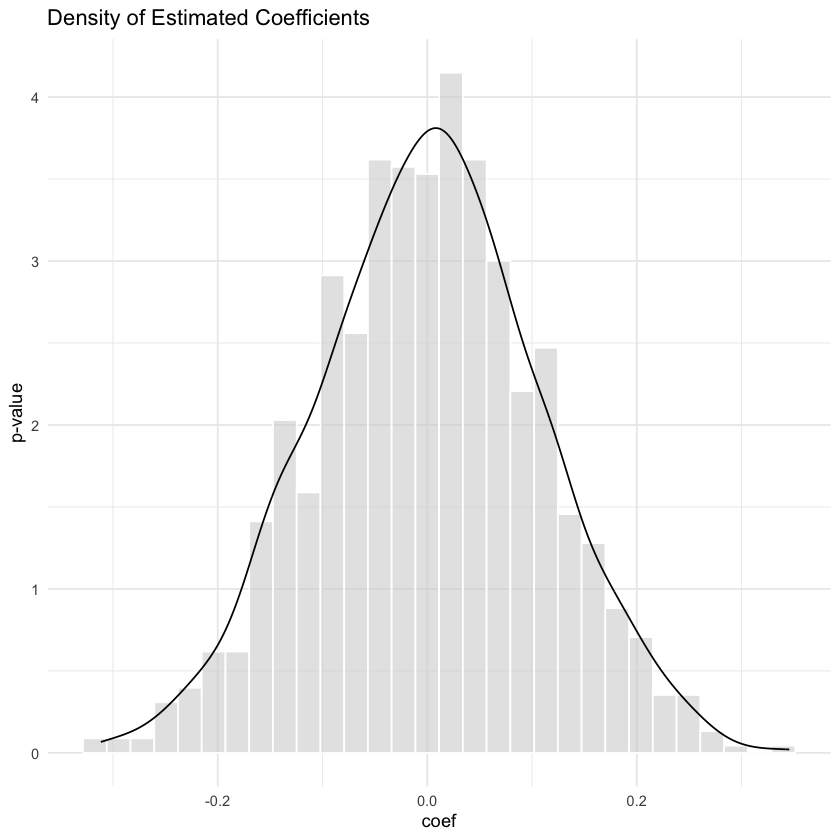

In [42]:
# 绘制系数的核密度曲线以及p值与系数的散点图
library(ggplot2)

ggplot(result_df, aes(x = estimate)) +
  geom_histogram(
    aes(x = estimate, y = after_stat(density)),
    bins = 30, fill = "lightgray", color = "white", alpha = 0.6
  ) +
  geom_density() +
  labs(
    title = "Density of Estimated Coefficients",
    x = "coef",
    y = "p-value"
  ) +
  theme_minimal()

In [44]:
# 数据预处理
hospdd_pre <- hospdd %>% 
  mutate(
    procedure = as.factor(procedure),
    hospital = as.factor(hospital),
    month = as.factor(month)
  )

# 拟合模型
fit_fe <- feols(
  satis ~ procedure + frequency | hospital + month,
  cluster = ~hospital,
  data = hospdd_pre
)

# 提取系数
coef <- tidy(fit_fe)[1, 2]

# 进行双边置换检验
result_df %>% 
  mutate(
    estimate = abs(estimate) >= abs(coef),
    estimate = as.numeric(estimate)
  )  %>% 
  summarise(p_value = mean(estimate))

p_value
<dbl>
0


# 面板DID

In [2]:
# 加载必要包
library(dplyr)

# 设置参数
set.seed(123)
n_units <- 100   # 个体数量
n_years <- 6     # 年份数量（如2015-2020）
years <- 2015:2020

# 构建面板数据框架
df <- expand.grid(
  id = 1:n_units,
  year = years
)

# 指定处理组（前50个单位）
df <- df %>%
  mutate(
    treat = ifelse(id <= 50, 1, 0),
    post = ifelse(year >= 2018, 1, 0),
    did = treat * post
  )

# 模拟结果变量 y
# 基础值 + 年份趋势 + 处理效应 + 随机扰动
df <- df %>%
  mutate(
    alpha_i = rnorm(n_units)[id],         # 个体固定效应
    lambda_t = year - 2015,               # 时间趋势
    treatment_effect = 2 * did,           # 政策效应（仅处理组在2018年后生效）
    epsilon = rnorm(n()),                 # 随机误差
    y = 5 + alpha_i + 0.5 * lambda_t + treatment_effect + epsilon
  )

# 查看前几行
head(df)


,id,year,treat,post,did,alpha_i,lambda_t,treatment_effect,epsilon,y
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2015,1,0,0,-0.56047565,0,0,-0.71040656,3.729118
2,2,2015,1,0,0,-0.23017749,0,0,0.25688371,5.026706
3,3,2015,1,0,0,1.55870831,0,0,-0.24669188,6.312016
4,4,2015,1,0,0,0.07050839,0,0,-0.34754260,4.722966
5,5,2015,1,0,0,0.12928774,0,0,-0.95161857,4.177669
6,6,2015,1,0,0,1.71506499,0,0,-0.04502772,6.670037


In [22]:
library(fixest)
feols(y ~ did | treat + year, data = df, vcov = "HC1") %>% summary()

OLS estimation, Dep. Var.: y
Observations: 600
Fixed-effects: treat: 2,  year: 6
Standard-errors: Heteroskedasticity-robust 
    Estimate Std. Error t value  Pr(>|t|)    
did  2.08109   0.209546 9.93145 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.27462     Adj. R2: 0.558836
                Within R2: 0.142816

In [20]:
fit <- lm(y ~ did + factor(treat) + factor(year), data = df)
# 使用稳健标准误
library(sandwich)
library(lmtest)
library(broom)
tidy(coeftest(fit, vcov = vcovHC(fit, type = "HC1")))

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),5.1178822,0.1431393,35.754563,5.167502e-150
did,2.0810933,0.2095458,9.931448,1.329898e-21
factor(treat)1,-0.2700462,0.1488114,-1.814688,7.007782e-02
factor(year)2016,0.7280119,0.1770332,4.112291,4.471730e-05
factor(year)2017,1.0713239,0.1870331,5.727992,1.618072e-08
factor(year)2018,1.6728511,0.2033802,8.225239,1.240080e-15
factor(year)2019,2.0247002,0.2042685,9.911956,1.572344e-21
factor(year)2020,2.4173560,0.2101967,11.500447,9.120469e-28


# 多期DID

## 美国银行监管

In [ ]:
# 导入数据集
library(haven)

bank <- read_dta("./data/macro_workfile.dta")
glimpse(bank)

Rows: 1,519
Columns: 137
$ `_intra`           <dbl> 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ~
$ ass4_ass           <dbl> 0.1199786, 0.1174541, 0.1197827, 0.1205712, 0.12448~
$ bankpow            <dbl> 1, 1, 1, 1, 1, 1, NA, NA, NA, NA, NA, NA, NA, NA, N~
$ branch_reform      <dbl> 1981, 1981, 1981, 1981, 1981, 1981, 1981, 1981, 198~
$ cap_dif4           <dbl> 0.02422019, 0.02402649, 0.02251819, 0.02442059, 0.0~
$ death              <dbl> 0, 0, 0, 0, 0, 1, NA, NA, NA, NA, NA, NA, NA, NA, N~
$ dem                <dbl> 1, 1, 1, 1, 1, 1, NA, NA, NA, NA, NA, NA, NA, NA, N~
$ e_interp           <dbl> 0.8833063, 0.8828573, 0.8824081, 0.8819591, 0.88151~
$ gini               <dbl> 0.4268312, 0.4201466, 0.4454181, 0.4630798, 0.43449~
$ gsp_pc             <dbl> 19601.85, 19941.30, 20924.97, 20556.36, 19291.91, 1~
$ gsp_pc_growth      <dbl> 0.058471795, 0.017317401, 0.049327873, -0.017615488~
$ ins_bkva           <dbl> 0.5701023, 0.5583705, 0.5542651, 0.5228887, 0.51296~
$ ins_dum      

In [45]:
head(bank)

_intra,ass4_ass,bankpow,branch_reform,cap_dif4,death,dem,e_interp,gini,gsp_pc,...,small_firms,state,state_name,statefip,theil,unemploymentrate,uniform,unit,unit_banking,wrkyr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.1199786,1,1981,0.02422019,0,1,0.8833063,0.4268312,19601.85,...,0.8833063,AL,Alabama,1,0.3085082,6.4,1,0,0,1976
0,0.1174541,1,1981,0.02402649,0,1,0.8828573,0.4201466,19941.30,...,0.8833063,AL,Alabama,1,0.2985663,6.8,1,0,0,1977
0,0.1197827,1,1981,0.02251819,0,1,0.8824081,0.4454181,20924.97,...,0.8833063,AL,Alabama,1,0.3377605,5.9,1,0,0,1978
0,0.1205712,1,1981,0.02442059,0,1,0.8819591,0.4630798,20556.36,...,0.8833063,AL,Alabama,1,0.3656532,6.8,1,0,0,1979
0,0.1244859,1,1981,0.01912699,0,1,0.8815100,0.4344939,19291.91,...,0.8833063,AL,Alabama,1,0.3213118,8.4,1,0,0,1980
0,0.1236748,1,1981,0.01551929,1,1,0.8810609,0.4543261,19378.35,...,0.8833063,AL,Alabama,1,0.3543027,9.7,1,0,0,1981


In [47]:
# 转化变量
# 基尼系数为结局，取对数
bank_pre <- bank %>%
  mutate(
    log_gini = log(gini)
  )

In [56]:
# 固定效应模型
library(fixest)

fit_fe <- feols(
  log_gini ~ `_intra` | statefip + wrkyr,
  data = bank_pre,
  cluster = ~ statefip,
)

summary(fit_fe)

OLS estimation, Dep. Var.: log_gini
Observations: 1,519
Fixed-effects: statefip: 49,  wrkyr: 31
Standard-errors: Clustered (statefip) 
          Estimate Std. Error  t value  Pr(>|t|)    
`_intra` -0.021987   0.007525 -2.92175 0.0052925 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.036574     Adj. R2: 0.51169 
                 Within R2: 0.025773

In [58]:
# 加入协变量
fit_fe_cov <- feols(
  log_gini ~ `_intra` + gsp_pc_growth + prop_blacks +
              prop_dropouts + prop_female_headed +
              unemploymentrate | statefip + wrkyr,
  data = bank_pre,
  cluster = ~ statefip,
)

summary(fit_fe_cov)

OLS estimation, Dep. Var.: log_gini
Observations: 1,519
Fixed-effects: statefip: 49,  wrkyr: 31
Standard-errors: Clustered (statefip) 
                    Estimate Std. Error   t value   Pr(>|t|)    
`_intra`           -0.017724   0.006403 -2.767940 7.9911e-03 ** 
gsp_pc_growth      -0.028842   0.041250 -0.699200 4.8780e-01    
prop_blacks        -0.212850   0.158496 -1.342932 1.8561e-01    
prop_dropouts       0.164163   0.071315  2.301945 2.5720e-02 *  
prop_female_headed  0.019040   0.056497  0.337015 7.3757e-01    
unemploymentrate    0.006333   0.001265  5.006601 7.8824e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.035475     Adj. R2: 0.538988
                 Within R2: 0.083432

In [61]:
bank %>% 
  select(statefip, wrkyr, branch_reform) %>% 
  filter(statefip == 1)

statefip,wrkyr,branch_reform
<dbl>,<dbl>,<dbl>
1,1976,1981
1,1977,1981
1,1978,1981
1,1979,1981
1,1980,1981
1,1981,1981
1,1982,1981
1,1983,1981
1,1984,1981


In [62]:
bank %>% 
  select(statefip, wrkyr, branch_reform) %>% 
  filter(statefip == 2)

statefip,wrkyr,branch_reform
<dbl>,<dbl>,<dbl>
2,1976,1960
2,1977,1960
2,1978,1960
2,1979,1960
2,1980,1960
2,1981,1960
2,1982,1960
2,1983,1960
2,1984,1960


In [78]:
# 进行平行趋势检验
m = 5  # 处理前
n = 10  # 处理后

bank_pre <- bank_pre %>% 
  mutate(
    t = wrkyr - branch_reform,
    t = ifelse(t <= -m, -m, t),
    t = ifelse(t >= n, n, t),
    t = as.factor(t)
  )

head(bank_pre)

_intra,ass4_ass,bankpow,branch_reform,cap_dif4,death,dem,e_interp,gini,gsp_pc,...,state_name,statefip,theil,unemploymentrate,uniform,unit,unit_banking,wrkyr,log_gini,t
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,0.1199786,1,1981,0.02422019,0,1,0.8833063,0.4268312,19601.85,...,Alabama,1,0.3085082,6.4,1,0,0,1976,-0.8513666,-5
0,0.1174541,1,1981,0.02402649,0,1,0.8828573,0.4201466,19941.30,...,Alabama,1,0.2985663,6.8,1,0,0,1977,-0.8671515,-4
0,0.1197827,1,1981,0.02251819,0,1,0.8824081,0.4454181,20924.97,...,Alabama,1,0.3377605,5.9,1,0,0,1978,-0.8087420,-3
0,0.1205712,1,1981,0.02442059,0,1,0.8819591,0.4630798,20556.36,...,Alabama,1,0.3656532,6.8,1,0,0,1979,-0.7698559,-2
0,0.1244859,1,1981,0.01912699,0,1,0.8815100,0.4344939,19291.91,...,Alabama,1,0.3213118,8.4,1,0,0,1980,-0.8335734,-1
0,0.1236748,1,1981,0.01551929,1,1,0.8810609,0.4543261,19378.35,...,Alabama,1,0.3543027,9.7,1,0,0,1981,-0.7889401,0


In [103]:
# DID
fit_DID <- feols(
  log_gini ~ i(t, ref = "0") + gsp_pc_growth + prop_blacks +  # 显示指定0为参照
             prop_dropouts | statefip + wrkyr,
  data = bank_pre,
  vcov = "HC1"
)

result <- tidy(fit_DID, conf.int = TRUE) %>% 
  # 只提取t开头的行
  filter(str_detect(term, "^t")) %>% 
  # 只保留需要的行
  select(term, estimate, conf.low, conf.high)

In [104]:
# 计算前m项均值
mean_m <- mean(result$estimate[1:m])

# 减去均值
result <- result %>% 
  mutate(
    across(
      .cols = c(estimate, conf.low, conf.high),
      .fns = \(x) x - mean_m
    )
  )

head(result)

term,estimate,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>
t::-5,0.006034193,-0.00755830,0.019626687
t::-4,0.004054357,-0.01153074,0.019639451
t::-3,-0.008061070,-0.02404658,0.007924440
t::-2,-0.005263431,-0.02069671,0.010169843
t::-1,0.003235950,-0.01256906,0.019040962
t::1,-0.010799945,-0.02650703,0.004907142


In [ ]:
# 添加t=0行
tibble_0 <- tibble(
  term = "t=0",
  estimate = -mean_m,
  conf.low = NA,
  conf.high = NA
)

# 合并tibble
result <- bind_rows(result, tibble_0)

term,estimate,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>
t::-5,0.006034193,-0.00755830,0.019626687
t::-4,0.004054357,-0.01153074,0.019639451
t::-3,-0.008061070,-0.02404658,0.007924440
t::-2,-0.005263431,-0.02069671,0.010169843
t::-1,0.003235950,-0.01256906,0.019040962
t::1,-0.010799945,-0.02650703,0.004907142
t::2,-0.007526194,-0.02333919,0.008286799
t::3,-0.017178117,-0.03249242,-0.001863814
t::4,-0.018813529,-0.03425921,-0.003367845


In [139]:
# 重新排序
result <- result %>% 
  mutate(
    order = row_number(),
    order = ifelse(term == "t=0", m+0.5, order)
  ) %>% 
  arrange(order)

# term重命名
result <- result %>% 
  mutate(
    term = str_c(
      "t",
      ifelse(row_number() <= m + 1, "", "+"),
      ifelse(row_number() == m + 1, "", row_number() - m - 1)
    )
  )

result

term,estimate,conf.low,conf.high,order
<chr>,<dbl>,<dbl>,<dbl>,<int>
t-5,0.006034193,-0.00755830,0.019626687,1
t-4,0.004054357,-0.01153074,0.019639451,2
t-3,-0.008061070,-0.02404658,0.007924440,3
t-2,-0.005263431,-0.02069671,0.010169843,4
t-1,0.003235950,-0.01256906,0.019040962,5
t,-0.007421593,NA,NA,6
t+1,-0.010799945,-0.02650703,0.004907142,7
t+2,-0.007526194,-0.02333919,0.008286799,8
t+3,-0.017178117,-0.03249242,-0.001863814,9


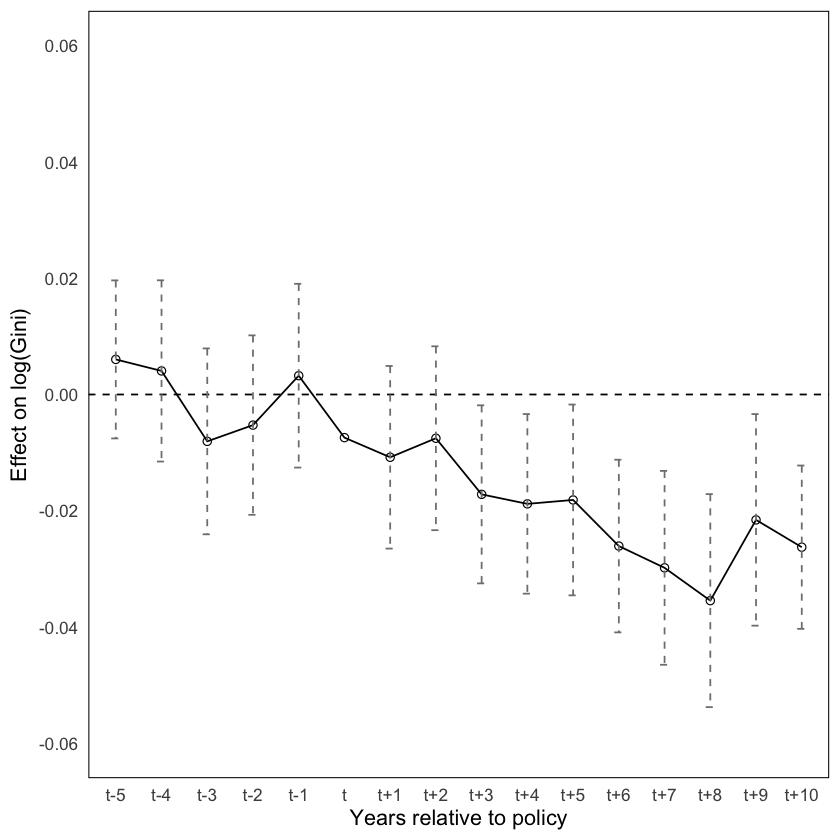

In [162]:
# 绘制折线图
library(ggplot2)
library(ggsci)

ggplot(result, aes(x = reorder(term, order), y = estimate)) +
  geom_hline(yintercept = 0, linetype = "dashed") +  # y=0 参考线
  geom_vline(xintercept = 0, linetype = "dashed") +  # t=0 参考线
  geom_point(shape = 1, size = 2) +  # 空心圆点
  geom_line(aes(group = 1), color = "black", linewidth = 0.5) +  # 连线
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), 
                width = 0.2, linetype = "dashed", color = "gray50") +  # 虚线置信区间
  labs(
    x = "Years relative to policy",
    y = "Effect on log(Gini)"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    # 去除网格
    panel.grid.major = element_blank(),
    # 去除小网格
    panel.grid.minor = element_blank(),
    # 保留坐标轴
    panel.border = element_rect(fill = NA, color = "black"),
    # 保留坐标轴minor
    axis.text.x = element_text(angle = 0, hjust = 0.5)
  ) +
  # 设置配色
  scale_color_npg() +
  scale_fill_npg() +
  # 设置坐标轴范围
  scale_y_continuous(
    limits = c(-0.06, 0.06),
    breaks = seq(-0.06, 0.06, by = 0.02)  
  )

In [178]:
# 假设检验，检验前五项系数是否显著为0
library(sandwich)
library(car)

linearHypothesis(
  fit_DID,
  c("t::-1 = 0", "t::-2 = 0", "t::-3 = 0", "t::-4 = 0", "t::-5 = 0"),
  vcov = \(x) vcovCL(x, cluster = ~ statefip),
  test = "F"
)

,Res.Df,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
1,1427,NA,NA,NA
2,1422,5,1.343216,0.243332


## 通商口岸影响

# DDD

In [67]:
# 读取数据
library(haven)
data <- read_dta("./data/so2_pre.dta")

glimpse(data)

Rows: 6,648
Columns: 77
$ company   <dbl> 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, ~
$ area      <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, ~
$ year      <dbl> 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, ~
$ bh        <dbl> 82004, 82005, 82006, 82007, 82008, 82009, 82010, 82011, 8201~
$ roa       <dbl> 0.5102, -0.0581, -0.0210, 0.0216, 0.0095, 0.0040, 0.0113, -0~
$ dzbq      <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ~
$ city      <dbl> 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 95, 95, 95, ~
$ tf        <dbl> 302.7455, 302.7455, 302.7455, 302.7455, 302.7455, 302.7455, ~
$ so2       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ~
$ open      <dbl> 17810497, 28381131, 38951765, 49522399, 56800198, 53341480, ~
$ var11     <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, ~
$ ind       <dbl> 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 30, 30, 30, ~
$ treat     <dbl

In [69]:
library(fixest)

# 过滤 SO2 排放企业
data_so2 <- subset(data, so2 == 1)

# 回归模型
fit_DID <- feols(
  lntfp ~ tt + zcsy + lf + age + owner + sczy + lnaj +
          lnlabor + lnzlb | year + area + ind,
  cluster = ~area,
  data = data_so2
)

# 查看结果
tidy(fit_DID)

NOTE: 1 observation removed because of NA values (RHS: 1).



term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
tt,0.270778261,0.065772084,4.116918,2.766469e-04
zcsy,0.012842176,0.002157506,5.952325,1.593145e-06
lf,-0.006883898,0.005998033,-1.147693,2.601658e-01
age,-0.004366079,0.003649566,-1.196328,2.409382e-01
owner,0.098855953,0.064416765,1.534631,1.353546e-01
sczy,0.021446614,0.007329202,2.926187,6.483765e-03
lnaj,0.059886047,0.027455541,2.181201,3.713996e-02
lnlabor,0.159244989,0.032390930,4.916345,2.950167e-05
lnzlb,0.062477419,0.015237705,4.100186,2.897373e-04


In [75]:
# 过滤 SO2 排放企业
data_so2 <- data %>%
  filter(so2 == 1) %>% 
  mutate(
    tt = as.factor(tt),
    ttt = as.factor(ttt),
    treats = as.factor(treats),
    times = as.factor(times)
  )

# 面板固定效应回归（公司 × 年固定效应 + 聚类标准误）
fit_DID <- feols(
  lntfp ~ factor(tt) + zcsy + lf + age + owner + sczy + lnaj +
          lnlabor + lnzlb | year + company,
  cluster = ~area,
  data = data_so2
)

# 查看结果
tidy(fit_DID)

NOTE: 1 observation removed because of NA values (RHS: 1).

The variables 'age' and 'owner' have been removed because of collinearity (see $collin.var).



term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
factor(tt)1,0.276836480,0.067788752,4.0838114,3.031365e-04
zcsy,0.009171188,0.001693129,5.4167090,7.182241e-06
lf,-0.006199590,0.005863569,-1.0573067,2.988116e-01
sczy,0.006471731,0.002401787,2.6945487,1.143346e-02
lnaj,0.077276207,0.024384828,3.1690282,3.507215e-03
lnlabor,0.036794625,0.051559989,0.7136275,4.809729e-01
lnzlb,-0.015530264,0.021778891,-0.7130879,4.813019e-01


In [77]:
# 处理数据
data_so2 <- data %>%
  mutate(
    tt = as.factor(tt),
    ttt = as.factor(ttt),
    treats = as.factor(treats),
    times = as.factor(times)
  )

# 回归模型：三重差分 + 控制变量 + 多维固定效应 + 聚类标准误
fit_ddd <- feols(
  lntfp ~ ttt + tt + treats + times + so2 + zcsy + lf + owner + age + sczy + lnaj + lnlabor + lnzlb | year + area + ind,
  cluster = ~area,
  data = data_so2
)

# 查看结果
tidy(fit_ddd)

NOTE: 3 observations removed because of NA values (RHS: 3).



term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ttt1,0.468231029,0.106071866,4.414281,1.210041e-04
tt1,-0.197212743,0.081012134,-2.434361,2.108211e-02
treats1,-0.254449802,0.116524046,-2.183668,3.694110e-02
times1,-0.363362318,0.063037100,-5.764261,2.699249e-06
so2,0.282456096,0.074462260,3.793279,6.717071e-04
zcsy,0.014336537,0.001877965,7.634080,1.629807e-08
lf,-0.004146686,0.003843250,-1.078953,2.892075e-01
owner,0.038196347,0.035106493,1.088014,2.852530e-01
age,-0.004166109,0.002989531,-1.393566,1.736877e-01


In [78]:
# 面板固定效应回归（公司 × 年固定效应 + 聚类标准误）
fit_xtreg <- feols(
  lntfp ~ ttt + tt + treats + times + so2 + zcsy + lf + owner +
          age + sczy + lnaj + lnlabor + lnzlb | year + company,
  cluster = ~area,
  data = data_so2
)

# 查看结果
tidy(fit_xtreg)

NOTE: 3 observations removed because of NA values (RHS: 3).

The variables 'treats1', 'so2', 'owner' and 'age' have been removed because of collinearity (see $collin.var).



term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ttt1,0.450881147,0.112522013,4.0070483,3.745187e-04
tt1,-0.178022827,0.083719970,-2.1264082,4.181033e-02
times1,-0.377583955,0.067518225,-5.5923264,4.377819e-06
zcsy,0.010116921,0.001502455,6.7335919,1.831359e-07
lf,-0.004079874,0.003974318,-1.0265596,3.128344e-01
sczy,0.010042291,0.003439919,2.9193395,6.595230e-03
lnaj,0.049197978,0.018034319,2.7280198,1.054678e-02
lnlabor,0.071599216,0.031558393,2.2687852,3.063814e-02
lnzlb,0.004153303,0.013843341,0.3000217,7.662297e-01


# PSM-DID

In [1]:
# 导入数据
library(haven)
library(tidyverse)
data_psm <- read_dta("./data/psmdata.dta")
glimpse(data_psm)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Rows: 81,567
Columns: 29
$ year      <dbl> 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998, ~
$ ind3      <dbl> 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 81, 81, 91, 91, 91, ~
$ ind2      <dbl> 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 9, 9, 9, 9, 9, 10, 10, 1~
$ prov      <dbl> 14, 14, 15, 34, 37, 41, 41, 42, 50, 14, 13, 14, 43, 44, 45, ~
$ city      <dbl> 1401, 1407, 1504, 3404, 3704, 4101, 4112, 4205, 5000, 1407, ~
$ ADM       <dbl> 0.0781305507, 0.1510689557, 0.1466887444, 0.1858219504, 0.06~
$ PPE       <dbl> 0.5354312, 0.4654047, 0.4124271, 0.3464146, 0.3111111, 0.576~
$ ADV       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ~
$ RD        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ~
$ HHI       <dbl> 0.74203205, 0.27833742, 0.42067245, 0.46802372, 0.26424834, ~
$ INDSIZE   <dbl> 14.75828, 14.16146, 13.67045, 15.02211, 15.02790, 15.37570, ~
$ MARGIN    <dbl> 0.6045173, 0.9311907, 0.5324503, 0.4424164, 0.7561751, 0.827~
$ FCFIRM    <db

## 截面PSM

In [24]:
# 加载必要的包
library(MatchIt)

# 设置随机种子
set.seed(123)

# 打乱顺序（模拟 Stata 中的 rnormal 排序）
data_psm_pre <- data_psm %>%
  mutate(random_order = sample(1:nrow(data_psm))) %>%
  arrange(random_order)

match_out <- matchit(
  treated ~ ADM + PPE + ADV + RD + HHI + INDSIZE + NFIRMS +
            FCFIRM + MARGIN + LEVDISP + SIZEDISP + ENTRYR + EXITR,
  data = data_psm_pre,
  method = "nearest",
  distance = "logit",
  ratio = 2,
  caliper = 0.05,
  discard = "both",
  ties = TRUE
)

# 查看匹配结果
summary(match_out)

Warning message:
"Fewer control units than treated units; not all treated units will get
a match."



Call:
matchit(formula = treated ~ ADM + PPE + ADV + RD + HHI + INDSIZE + 
    NFIRMS + FCFIRM + MARGIN + LEVDISP + SIZEDISP + ENTRYR + 
    EXITR, data = data_psm_pre, method = "nearest", distance = "logit", 
    discard = "both", caliper = 0.05, ratio = 2, ties = TRUE)

Summary of Balance for All Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.5632        0.4918          0.5427     1.1366    0.1572
ADM             0.0752        0.0658          0.1132     1.0730    0.0596
PPE             0.3453        0.4087         -0.3020     0.9316    0.0874
ADV             0.0004        0.0004          0.0415     1.2587    0.0099
RD              0.0005        0.0003          0.0620     1.6268    0.0107
HHI             0.2341        0.2674         -0.2000     0.9530    0.0706
INDSIZE        13.2786       12.8730          0.2983     1.0079    0.0895
NFIRMS          2.6806        2.3742          0.3534     1.3469    0.0421
FCFIRM          0.0161      

In [25]:
# 使用cobalt包
library(cobalt)

bal.tab(
  match_out,
  un = TRUE,
  stats = c("m", "v", "ks")
)

Balance Measures
             Type Diff.Un V.Ratio.Un  KS.Un Diff.Adj V.Ratio.Adj KS.Adj
distance Distance  0.5427     1.1366 0.2348   0.0358      1.0292 0.0254
ADM       Contin.  0.1132     1.0730 0.1047   0.0137      0.8268 0.0773
PPE       Contin. -0.3020     0.9316 0.1299  -0.0129      1.0194 0.0125
ADV       Contin.  0.0415     1.2587 0.0133   0.0075      1.0232 0.0041
RD        Contin.  0.0620     1.6268 0.0143  -0.0012      0.9921 0.0024
HHI       Contin. -0.2000     0.9530 0.1142  -0.0063      0.9865 0.0090
INDSIZE   Contin.  0.2983     1.0079 0.1293   0.0205      0.8789 0.0276
NFIRMS    Contin.  0.3534     1.3469 0.1689   0.0188      0.9418 0.0241
FCFIRM    Contin.  0.1302     2.1568 0.0374   0.0247      1.1516 0.0095
MARGIN    Contin.  0.0292     1.0055 0.0350   0.0009      1.0303 0.0253
LEVDISP   Contin. -0.1784     0.8073 0.0844  -0.0107      0.9894 0.0206
SIZEDISP  Contin.  0.0867     0.8512 0.0611   0.0089      0.9628 0.0145
ENTRYR    Contin. -0.0345     0.9204 0.0146  -0

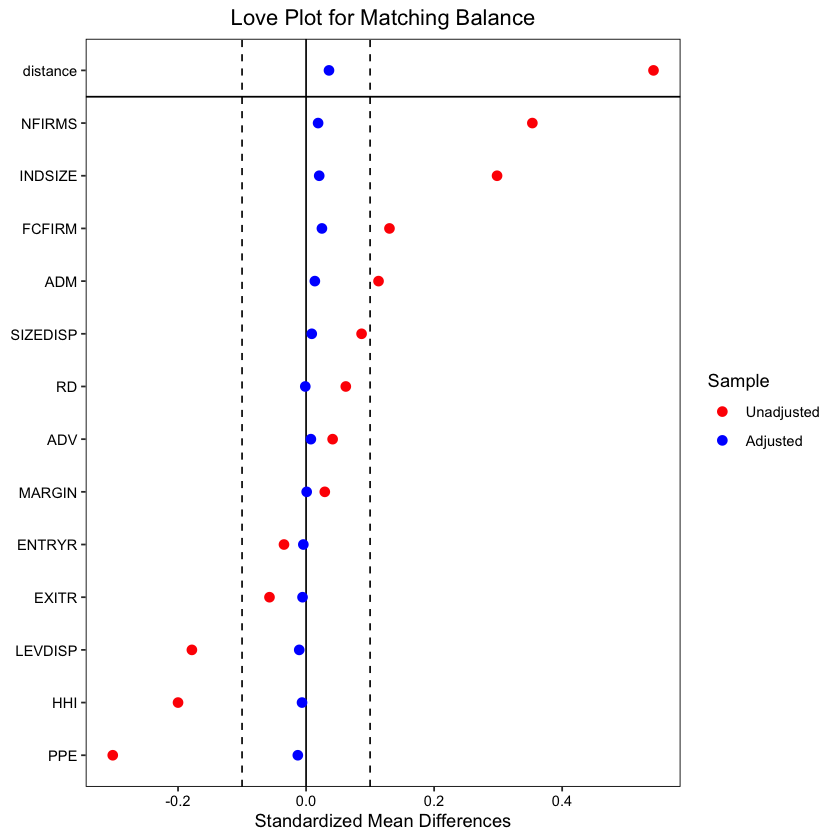

In [26]:
# love图
love.plot(
  match_out,
  threshold = 0.1,
  var.order = "un",
  colors = c("red", "blue"),
  stars = TRUE,
  title = "Love Plot for Matching Balance"
)

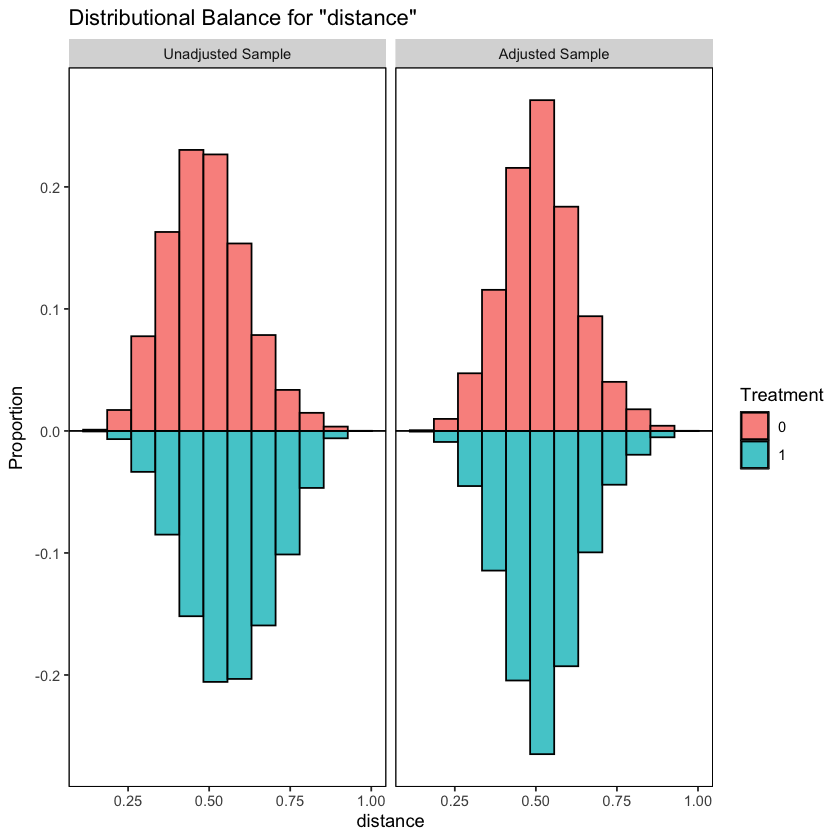

In [27]:
# 绘制共同支撑
bal.plot(
  match_out,
  var.name = "distance",
  which = "both",
  type = "histogram",
  mirror = TRUE
)

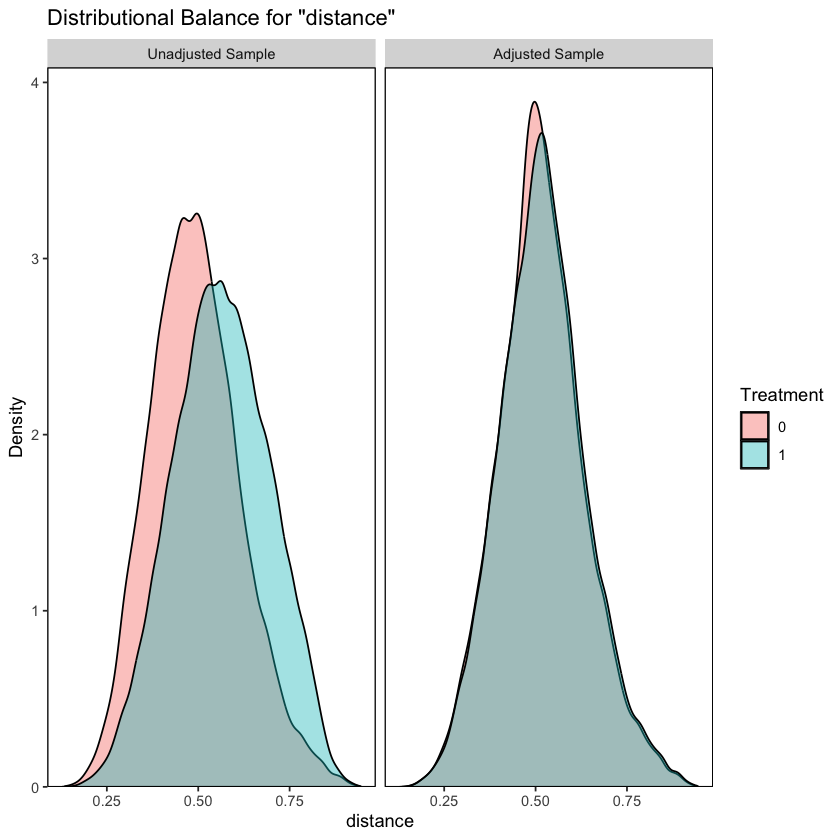

In [28]:
bal.plot(
  match_out,
  var.name = "distance",
  which = "both"
)

In [29]:
match_data <- match.data(match_out)
head(match_data)

year,ind3,ind2,prov,city,ADM,PPE,ADV,RD,HHI,...,TFPSD_OP,TFPSD_LP,TFPQD_OP,TFPQD_LP,NFIRMS,treated,random_order,distance,weights,subclass
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>
2004,358,35,62,6205,0.015479876,0.8774496,0.000000000,0,0.2956718,...,1.0620096,0.9787399,2.566029,2.301443,1.609438,0,1,0.1739470,0.5976211,22447
2002,414,41,44,4420,0.077345192,0.5204276,0.000000000,0,0.2743882,...,1.0239774,1.2077894,2.412938,3.022373,1.791759,1,3,0.3194581,1.0000000,1
2006,345,34,44,4403,0.061667554,0.0735798,0.004461907,0,0.2320733,...,0.7413588,0.8556963,1.652549,1.716809,3.218876,1,4,0.7202706,1.0000000,2
1998,171,17,44,4412,0.006934307,0.5098040,0.000000000,0,0.1097609,...,1.3647889,0.9582680,3.304149,2.290294,2.772589,1,5,0.4359356,1.0000000,3
1998,265,26,37,3706,0.002092676,0.4500695,0.000000000,0,0.1807520,...,0.6513818,0.6007919,1.534053,1.454949,2.397895,0,7,0.3767874,0.5976211,31811
2007,262,26,37,3703,0.004266212,0.5405512,0.000000000,0,0.2885212,...,0.8754622,1.2991343,2.993169,4.080941,2.197225,0,9,0.4754708,1.1952421,26253


In [33]:
# 基准回归1：OLS + cluster(city)
library(fixest)
fit1 <- feols(
  TFPQD_OP ~ FB + ADM + PPE + ADV + RD + HHI + INDSIZE + NFIRMS +
             FCFIRM + MARGIN + LEVDISP + SIZEDISP + ENTRYR + EXITR,
  data = match_data,
  cluster = ~city
)

# 查看结果
library(broom)
tidy(fit1)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.60573828,0.14343212,4.2231704,3.052909e-05
FB,-0.12643447,0.02282263,-5.5398722,5.843388e-08
ADM,1.04085035,0.06355442,16.3773091,1.791058e-45
PPE,-0.12216394,0.02537116,-4.8150707,2.168263e-06
ADV,4.66912421,1.89591217,2.4627323,1.425446e-02
RD,-2.94806150,1.85158671,-1.5921812,1.122192e-01
HHI,-0.00625409,0.05751775,-0.1087332,9.134745e-01
INDSIZE,0.10469768,0.01623195,6.4501006,3.593572e-10
NFIRMS,-0.18276785,0.02505815,-7.2937498,1.925860e-12


In [34]:
# 基准回归2：固定效应 + cluster(city#ind3 city#year)
fit2 <- feols(
  TFPQD_OP ~ FB + ADM + PPE + ADV + RD + HHI + INDSIZE + NFIRMS +
             FCFIRM + MARGIN + LEVDISP + SIZEDISP + ENTRYR + EXITR |
             city + ind3,
  data = match_data,
  cluster = ~city:ind3 + city:year
)

# 查看结果
tidy(fit2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
FB,-0.05435836,0.013128661,-4.1404346,3.558116e-05
ADM,0.88686508,0.055348841,16.0231916,1.356240e-55
PPE,-0.08561111,0.016856553,-5.0788028,4.020790e-07
ADV,1.18172320,1.836167643,0.6435813,5.198942e-01
RD,-4.31962856,1.683465136,-2.5659151,1.033660e-02
HHI,0.15672118,0.039146008,4.0035035,6.386161e-05
INDSIZE,0.04056222,0.008003925,5.0677918,4.258404e-07
NFIRMS,-0.09174253,0.013065120,-7.0219433,2.672763e-12
FCFIRM,-0.07620509,0.076756432,-0.9928170,3.208760e-01


In [35]:
# PSM-DID
fit3 <- feols(
  TFPQD_OP ~ FB + ADM + PPE + ADV + RD + HHI + INDSIZE + NFIRMS +
             FCFIRM + MARGIN + LEVDISP + SIZEDISP + ENTRYR + EXITR |
             city + ind3,
  data = match_data,
  weights = match_data$weights,
  cluster = ~city:ind3 + city:year
)

# 查看结果
tidy(fit3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
FB,-0.05307384,0.013126502,-4.0432586,5.398557e-05
ADM,0.89038126,0.056434283,15.7773115,5.121343e-54
PPE,-0.08774385,0.016905752,-5.1901773,2.235122e-07
ADV,1.57755849,1.831872288,0.8611727,3.892089e-01
RD,-4.13941846,1.706852396,-2.4251766,1.535722e-02
HHI,0.15030853,0.039422489,3.8127610,1.400746e-04
INDSIZE,0.03994779,0.008127882,4.9149077,9.339721e-07
NFIRMS,-0.09937394,0.013177619,-7.5411151,6.069976e-14
FCFIRM,-0.08122186,0.077195244,-1.0521614,2.928068e-01


## 逐年PSM

In [36]:
# 定义年份范围
years <- 1998:2007

# 创建列表
results_list <- list()

# 循环遍历年份
for (year in years) {
  # 过滤数据
  data_year <- data_psm %>% filter(year == year)

  # 打乱顺序
  data_year <- data_year %>%
    mutate(random_order = sample(1:nrow(data_year))) %>%
    arrange(random_order)

  # 匹配
  match_out <- matchit(
    treated ~ ADM + PPE + ADV + RD + HHI + INDSIZE + NFIRMS +
              FCFIRM + MARGIN + LEVDISP + SIZEDISP + ENTRYR + EXITR,
    data = data_year,
    method = "nearest",
    distance = "logit",
    ratio = 2,
    caliper = 0.05,
    discard = "both",
    ties = TRUE
  )

  # 提取匹配数据
  match_data <- match.data(match_out)

  # 加入列表
  results_list[[as.character(year)]] <- match_data
}

# 合并数据
matched_data <- bind_rows(results_list, .id = "year")

Warning message:
"Fewer control units than treated units; not all treated units will get
a match."
Warning message:
"Fewer control units than treated units; not all treated units will get
a match."
Warning message:
"Fewer control units than treated units; not all treated units will get
a match."
Warning message:
"Fewer control units than treated units; not all treated units will get
a match."
Warning message:
"Fewer control units than treated units; not all treated units will get
a match."
Warning message:
"Fewer control units than treated units; not all treated units will get
a match."
Warning message:
"Fewer control units than treated units; not all treated units will get
a match."
Warning message:
"Fewer control units than treated units; not all treated units will get
a match."
Warning message:
"Fewer control units than treated units; not all treated units will get
a match."
Warning message:
"Fewer control units than treated units; not all treated units will get
a match."


In [37]:
# 查看结果
head(matched_data)

year,ind3,ind2,prov,city,ADM,PPE,ADV,RD,HHI,...,TFPSD_OP,TFPSD_LP,TFPQD_OP,TFPQD_LP,NFIRMS,treated,random_order,distance,weights,subclass
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>
1998,263,26,33,3310,0.137765825,0.3921530,0,0,0.39428505,...,0.4619111,0.7679052,1.338716,2.380572,1.945910,1,1,0.4923706,1.000000,1
1998,293,29,31,3100,0.121151835,0.2984888,0,0,0.05701792,...,0.6048511,0.5680621,1.551195,1.143546,3.178054,0,4,0.6332834,1.195242,4002
1998,331,33,33,3307,0.002541757,0.2859597,0,0,0.41285017,...,0.5499593,0.6030811,1.577118,2.032641,2.079442,1,6,0.5352982,1.000000,2
1998,266,26,37,3703,0.026592510,0.3100559,0,0,0.06683419,...,0.8469657,1.0288938,2.351878,2.693982,5.123964,0,7,0.7857239,1.195242,20397
1998,137,13,37,3712,0.017896572,0.6053752,0,0,0.14120451,...,0.8550395,0.6381029,2.379542,1.894228,2.302585,0,8,0.4334849,1.195242,24896
1998,358,35,45,4502,0.175422430,0.4186838,0,0,0.24538960,...,1.0610007,0.9216672,2.607548,2.239921,1.791759,1,9,0.4568690,1.000000,3


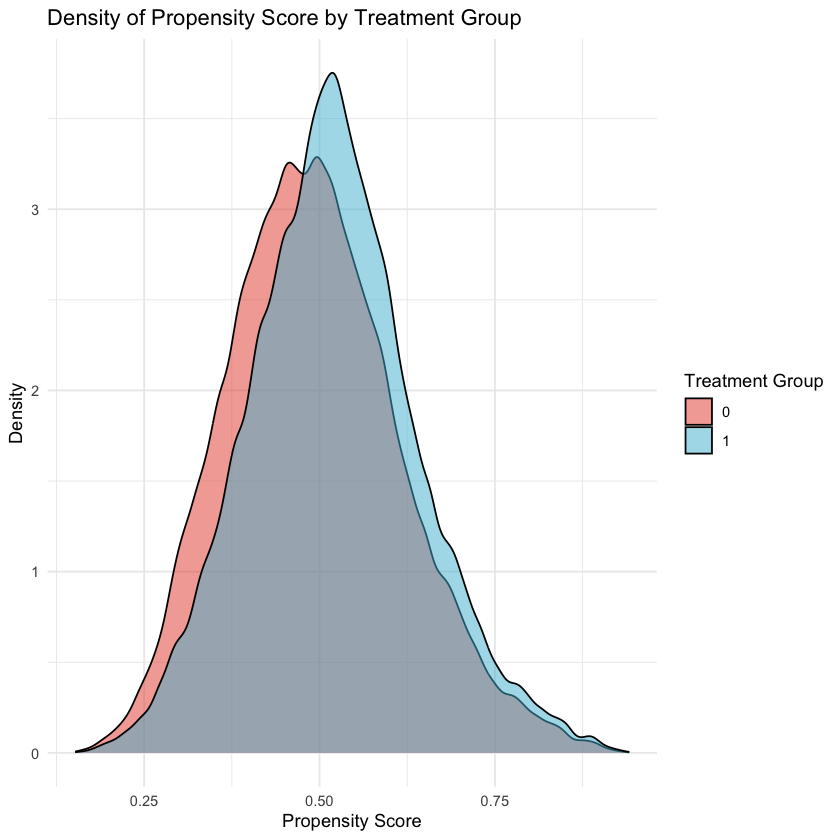

In [40]:
# 绘制核密度图
library(ggplot2)
library(ggsci)

ggplot(matched_data, aes(x = distance, fill = as.factor(treated))) +
  geom_density(alpha = 0.5) +
  labs(
    title = "Density of Propensity Score by Treatment Group",
    x = "Propensity Score",
    y = "Density",
    fill = "Treatment Group"
  ) +
  theme_minimal() +
  scale_fill_npg()

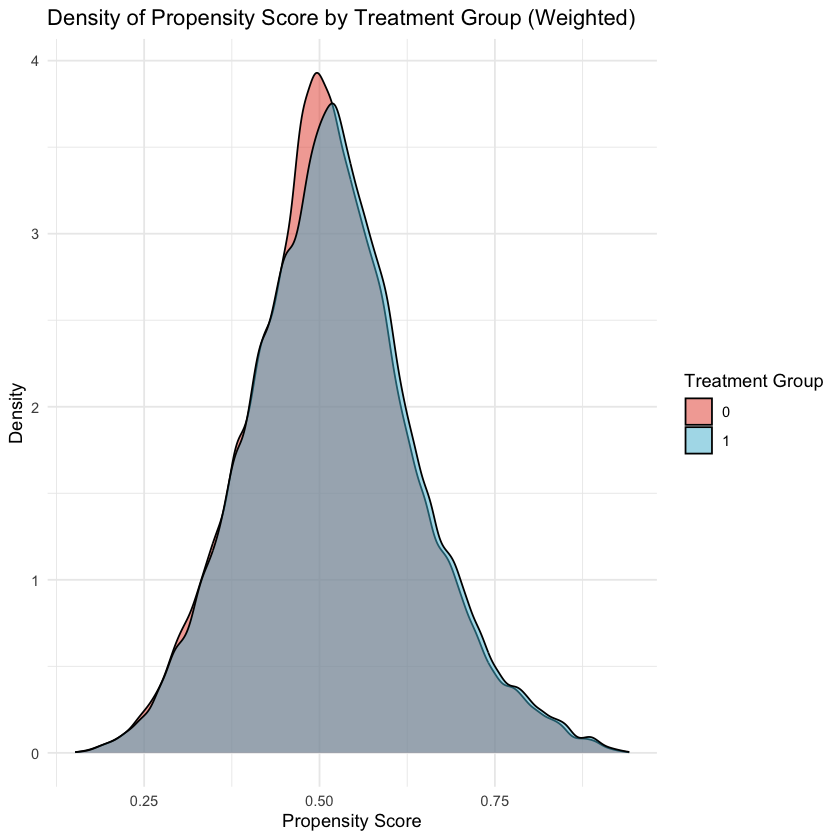

In [41]:
# 绘制匹配后核密度，包含权重
ggplot(matched_data, aes(x = distance, fill = as.factor(treated), weight = weights)) +
  geom_density(alpha = 0.5) +
  labs(
    title = "Density of Propensity Score by Treatment Group (Weighted)",
    x = "Propensity Score",
    y = "Density",
    fill = "Treatment Group"
  ) +
  theme_minimal() +
  scale_fill_npg()

In [53]:
# 每个年份进行PS的Logit回归，并汇总系数
results_list <- list()

for (year in years) {
  # 过滤数据
  data_year <- data_psm %>% filter(year == year)

  # logit回归
  fit_logit <- glm(
    treated ~ ADM + PPE + ADV + RD + HHI + INDSIZE + NFIRMS +
           FCFIRM + MARGIN + LEVDISP + SIZEDISP + ENTRYR + EXITR,
    family = binomial(link = "logit"),
    data = data_year
  )
  
  # 提取系数
  result <- tidy(fit_logit) %>%
    select(term, estimate)
  
  # 加入列表
  results_list[[as.character(year)]] <- result
}

# 合并数据，按照term进行连接
coef_results <- Reduce(function(x, y) merge(x, y, by = "term", all = TRUE), results_list)

#按年份重命名列
colnames(coef_results) <- c("term", paste0(years))

# 查看结果
# 设置小数
options(digits = 3)
coef_results

Warning message in merge.data.frame(x, y, by = "term", all = TRUE):
"column names 'estimate.x', 'estimate.y' are duplicated in the result"
Warning message in merge.data.frame(x, y, by = "term", all = TRUE):
"column names 'estimate.x', 'estimate.y' are duplicated in the result"
Warning message in merge.data.frame(x, y, by = "term", all = TRUE):
"column names 'estimate.x', 'estimate.y', 'estimate.x', 'estimate.y' are duplicated in the result"
Warning message in merge.data.frame(x, y, by = "term", all = TRUE):
"column names 'estimate.x', 'estimate.y', 'estimate.x', 'estimate.y' are duplicated in the result"
Warning message in merge.data.frame(x, y, by = "term", all = TRUE):
"column names 'estimate.x', 'estimate.y', 'estimate.x', 'estimate.y', 'estimate.x', 'estimate.y' are duplicated in the result"
Warning message in merge.data.frame(x, y, by = "term", all = TRUE):
"column names 'estimate.x', 'estimate.y', 'estimate.x', 'estimate.y', 'estimate.x', 'estimate.y' are duplicated in the result

term,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.94787,-0.94787,-0.94787,-0.94787,-0.94787,-0.94787,-0.94787,-0.94787,-0.94787,-0.94787
ADM,2.30343,2.30343,2.30343,2.30343,2.30343,2.30343,2.30343,2.30343,2.30343,2.30343
ADV,21.56327,21.56327,21.56327,21.56327,21.56327,21.56327,21.56327,21.56327,21.56327,21.56327
ENTRYR,-0.01034,-0.01034,-0.01034,-0.01034,-0.01034,-0.01034,-0.01034,-0.01034,-0.01034,-0.01034
EXITR,-0.11231,-0.11231,-0.11231,-0.11231,-0.11231,-0.11231,-0.11231,-0.11231,-0.11231,-0.11231
FCFIRM,2.68580,2.68580,2.68580,2.68580,2.68580,2.68580,2.68580,2.68580,2.68580,2.68580
HHI,-0.47299,-0.47299,-0.47299,-0.47299,-0.47299,-0.47299,-0.47299,-0.47299,-0.47299,-0.47299
INDSIZE,0.00157,0.00157,0.00157,0.00157,0.00157,0.00157,0.00157,0.00157,0.00157,0.00157
LEVDISP,-2.17840,-2.17840,-2.17840,-2.17840,-2.17840,-2.17840,-2.17840,-2.17840,-2.17840,-2.17840


In [54]:
# 每个年份进行PS的Logit回归，并汇总系数
results_list <- list()

for (year in years) {
  # 过滤数据
  data_year <- matched_data %>% filter(year == year)

  # logit回归
  fit_logit <- glm(
    treated ~ ADM + PPE + ADV + RD + HHI + INDSIZE + NFIRMS +
           FCFIRM + MARGIN + LEVDISP + SIZEDISP + ENTRYR + EXITR,
    family = binomial(link = "logit"),
    weights = weights,
    data = data_year
  )
  
  # 提取系数
  result <- tidy(fit_logit) %>%
    select(term, estimate)
  
  # 加入列表
  results_list[[as.character(year)]] <- result
}

# 合并数据，按照term进行连接
coef_results_after <- Reduce(function(x, y) merge(x, y, by = "term", all = TRUE), results_list)

#按年份重命名列
colnames(coef_results_after) <- c("term", paste0(years))

# 查看结果
# 设置小数
options(digits = 3)
coef_results_after

Warning message in merge.data.frame(x, y, by = "term", all = TRUE):
"column names 'estimate.x', 'estimate.y' are duplicated in the result"
Warning message in merge.data.frame(x, y, by = "term", all = TRUE):
"column names 'estimate.x', 'estimate.y' are duplicated in the result"
Warning message in merge.data.frame(x, y, by = "term", all = TRUE):
"column names 'estimate.x', 'estimate.y', 'estimate.x', 'estimate.y' are duplicated in the result"
Warning message in merge.data.frame(x, y, by = "term", all = TRUE):
"column names 'estimate.x', 'estimate.y', 'estimate.x', 'estimate.y' are duplicated in the result"
Warning message in merge.data.frame(x, y, by = "term", all = TRUE):
"column names 'estimate.x', 'estimate.y', 'estimate.x', 'estimate.y', 'estimate.x', 'estimate.y' are duplicated in the result"
Warning message in merge.data.frame(x, y, by = "term", all = TRUE):
"column names 'estimate.x', 'estimate.y', 'estimate.x', 'estimate.y', 'estimate.x', 'estimate.y' are duplicated in the result

term,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.33595,-0.33595,-0.33595,-0.33595,-0.33595,-0.33595,-0.33595,-0.33595,-0.33595,-0.33595
ADM,0.25789,0.25789,0.25789,0.25789,0.25789,0.25789,0.25789,0.25789,0.25789,0.25789
ADV,4.50688,4.50688,4.50688,4.50688,4.50688,4.50688,4.50688,4.50688,4.50688,4.50688
ENTRYR,-0.00898,-0.00898,-0.00898,-0.00898,-0.00898,-0.00898,-0.00898,-0.00898,-0.00898,-0.00898
EXITR,-0.01845,-0.01845,-0.01845,-0.01845,-0.01845,-0.01845,-0.01845,-0.01845,-0.01845,-0.01845
FCFIRM,0.60874,0.60874,0.60874,0.60874,0.60874,0.60874,0.60874,0.60874,0.60874,0.60874
HHI,-0.02042,-0.02042,-0.02042,-0.02042,-0.02042,-0.02042,-0.02042,-0.02042,-0.02042,-0.02042
INDSIZE,0.00558,0.00558,0.00558,0.00558,0.00558,0.00558,0.00558,0.00558,0.00558,0.00558
LEVDISP,-0.16568,-0.16568,-0.16568,-0.16568,-0.16568,-0.16568,-0.16568,-0.16568,-0.16568,-0.16568


In [60]:
# 基准回归1：OLS + cluster(city)
library(fixest)
fit1 <- feols(
  TFPQD_OP ~ FB + ADM + PPE + ADV + RD + HHI + INDSIZE + NFIRMS +
             FCFIRM + MARGIN + LEVDISP + SIZEDISP + ENTRYR + EXITR,
  data = data_psm_pre,
  cluster = ~city
)

# 查看结果
library(broom)
tidy(fit1)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.5835,0.1460,3.997,7.78e-05
FB,-0.1243,0.0237,-5.248,2.63e-07
ADM,1.0682,0.0606,17.639,1.16e-50
PPE,-0.1183,0.0272,-4.349,1.78e-05
ADV,3.4239,1.7755,1.928,5.46e-02
RD,-1.1993,1.4771,-0.812,4.17e-01
HHI,-0.0284,0.0555,-0.512,6.09e-01
INDSIZE,0.1061,0.0164,6.480,3.01e-10
NFIRMS,-0.2011,0.0286,-7.027,1.06e-11


In [62]:
# 基准回归2：固定效应 + cluster(city#ind3 city#year)
fit2 <- feols(
  TFPQD_OP ~ FB + ADM + PPE + ADV + RD + HHI + INDSIZE + NFIRMS +
             FCFIRM + MARGIN + LEVDISP + SIZEDISP + ENTRYR + EXITR |
             city + ind3,
  data = data_psm_pre,
  cluster = ~interaction(city, ind3) + interaction(city, year)
)

# 查看结果
tidy(fit2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
FB,-0.0496,0.01359,-3.653,2.63e-04
ADM,0.8719,0.04837,18.026,3.45e-69
PPE,-0.0845,0.01540,-5.487,4.42e-08
ADV,0.4029,1.58204,0.255,7.99e-01
RD,-3.5116,1.32153,-2.657,7.92e-03
HHI,0.1391,0.03723,3.737,1.90e-04
INDSIZE,0.0398,0.00776,5.123,3.19e-07
NFIRMS,-0.1012,0.01225,-8.264,2.06e-16
FCFIRM,-0.0343,0.06121,-0.560,5.75e-01


In [64]:
# PSM-DID
fit3 <- feols(
  TFPQD_OP ~ FB + ADM + PPE + ADV + RD + HHI + INDSIZE + NFIRMS +
             FCFIRM + MARGIN + LEVDISP + SIZEDISP + ENTRYR + EXITR |
             city + ind3,
  data = matched_data,
  weights = matched_data$weights,
  cluster = ~interaction(city, ind3) + interaction(city, year)
)

# 查看结果
tidy(fit3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
FB,-0.0531,0.00974,-5.447,5.46e-08
ADM,0.8904,0.05491,16.216,3.85e-57
PPE,-0.0877,0.01657,-5.297,1.25e-07
ADV,1.5776,1.68549,0.936,3.49e-01
RD,-4.1394,1.62843,-2.542,1.11e-02
HHI,0.1503,0.03901,3.853,1.19e-04
INDSIZE,0.0399,0.00765,5.220,1.89e-07
NFIRMS,-0.0994,0.01262,-7.871,4.60e-15
FCFIRM,-0.0812,0.07665,-1.060,2.89e-01


In [ ]:
# 平行趋势检验
